# Project 03: Clustering Human Recognition

Este proyecto busca detectar qué acción está realizando un humano por medio de un datasets de videos donde se realizan interacciones como: *tocar instrumentos, interacción de humanos con objetos, humanos saludándose, humanos abrazándose, etc*. Para cada acción se cuentan con como mínimo 400 video clips.

---
## 0. Libraries & setup

In [110]:
import os
import glob
import h5py
import umap.umap_ as umap

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from IPython.core.display import HTML
from matplotlib import rcParams

In [111]:
np.random.seed(11)
HTML("""<style>.output_png { display: table-cell; text-align: center; vertical-align: middle;}</style>""")
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 100
rcParams['grid.linewidth'] = 0.5

sns.set_palette(custom_colors)

---
## 1. Video features extraction

Cada clip tiene asociado con una sola acción humana y dura aproximadamente 10 sgundos. Este proyecto usa un subset del dataset original, se utilizará la librería de Video Fetures y Gluon para extraer las características del video.

Para proceder con el almacenamiento de los datos se utilizará un almacenamiento del tipo **HDF5** por medio de la librería `h5py`. De igual forma se procede a utiizar un modelo etiquetado como: **Action Recognition** para la extracción de características, esto es así pues a comparación del otro modelo **Frame-wise** nosotros tenemos como data acciones dinámicas y no estáticas.

El costo computacional para reconocimiento de acciones será más costoso pues analizará más frames por segundo, por ese motivo se elijió el modelo **R(2 + 1)D pre entrenado con Kinetics 400**, que si bien no es el más potente o el que brinda más características, pero si aquel que tiene un buen **tradeoff** entre eficiencia y precisión.

Necesitamos **extraer las características** de nuestros videos por medio de la librería que se ejecuta a nivel terminal, con el siguiente comando podremos transformar un listado de videos tal que obtenemos características para cada uno. Es así que contamos en la [documentación](https://v-iashin.github.io/video_features/models/s3d/) con argumentos opcionales, un ejemplo es el siguiente `python main.py feature_type = s3d video_paths="[./qyjw13RCjZk_000017_000027.mp4]" show_pred = true`

In [23]:
def extract_video_data(video_features_path, labels_df):
    video_features = []
    video_labels = []
    video_empty_frames = 0
    
    for each_video in glob.glob(os.path.join(video_features_path, '*.npy')):
        video_id = os.path.basename(each_video).split('_')[0]
        current_video_feature = np.load(each_video)

        if current_video_feature.size == 0:
            video_empty_frames += 1
            continue

        current_video_feature_avg = np.mean(current_video_feature, axis = 0)    
        video_features.append(current_video_feature_avg)

        current_video_label = labels_df[labels_df['video_id'] == video_id]['action'].values[0]
        video_labels.append(current_video_label)

    print(f'Número de videos vacíos no agregados ({video_features_path}): {video_empty_frames}')    
    
    video_features_stacked = np.vstack(video_features)
    video_labels_stacked = np.vstack(video_labels)
    
    df_features = pd.DataFrame(video_features_stacked)
    df_labels = pd.DataFrame(video_labels_stacked)

    return df_features, df_labels

df_train_labels = pd.read_csv('./data/train.csv', header = None, names = ['video_id', 'action'])
df_val_labels = pd.read_csv('./data/val.csv', header = None, names = ['video_id', 'action'])

X_train, Y_train = extract_video_data('./data/train_r2plus1d', df_train_labels)
X_train.dropna(inplace = True)
Y_train.dropna(inplace = True)

print(f'\nNúmero de videos cargados para entrenamiento: {len(X_train)}')
print(f'Shape de nuestra matriz de videos para entrenamiento: {X_train.shape}')

#X_val, Y_val = extract_video_data('./data/s3d/val', df_val_labels)
#X_val.dropna(inplace = True)
#Y_val.dropna(inplace = True)

#print(f'\nNúmero de videos cargados para validación: {len(X_val)}')
#print(f'Shape de nuestra matriz de videos para validación: {X_val.shape}')

Número de videos vacíos no agregados (./data/train_r2plus1d): 15

Número de videos cargados para entrenamiento: 10680
Shape de nuestra matriz de videos para entrenamiento: (10680, 512)


---
## 2. Data Exploration

Empezaremos creando un objeto dataframe donde vamos a enlazar lo obtenido en nuestra matriz de video con nuestros labels respectivamente que están **asociados al id** del video. De esta manera podemos visualizar nuestra información por medio de funciones como `describe()` ó `head()` inicialmente, para observar los datos obtenidos.

In [24]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.242180,1.816158,0.300869,0.508914,0.878099,2.106883,0.230155,0.605886,1.717578,0.220975,...,2.224597,1.160053,1.745876,1.194724,0.184887,0.747714,0.708895,0.644671,0.948748,1.352193
1,0.244687,0.701155,0.130313,1.231479,0.735281,1.491661,0.663805,0.162656,0.967933,0.321333,...,0.216478,0.953761,3.274144,0.326691,0.363385,1.000944,0.478444,0.377964,0.022678,2.470345
2,1.613469,0.204242,0.380671,1.139593,0.861478,0.967409,0.237919,0.040725,0.966192,0.904284,...,0.565021,0.173540,1.081915,0.279073,0.171813,1.165337,1.134483,0.023993,0.925138,0.210616
3,0.648069,0.950484,0.638856,0.453823,0.119610,0.547130,1.248594,0.980112,0.536282,0.798715,...,0.492563,0.307730,2.169735,0.263416,0.142741,0.773679,0.714081,1.775361,0.403796,1.168011
4,2.395824,1.128466,1.173637,0.694533,1.760470,3.760453,1.194253,0.113903,0.749546,1.136013,...,0.268048,2.654991,0.426021,0.224070,0.717765,0.316523,1.342660,0.994503,1.106563,0.656876


Si solicitamos las estadísticas descriptivas logramos observar para cada característica / feature su valor en media, cantidad de elementos, desviación estándar, mínimos, máximos, etc. En este caso todas nuestras columnas tienen $512$ elementos, por lo que no hay nulos. Además es posible notar que las medias son distintas, esto quiere decir que hay **diferentes puntos de activación para diferentes videos**. Es posible notar que el mínimo en casi todas las colummnas es $0$ lo que indica que hay características que en ciertos videos no están presentes o activadas.

In [25]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
count,10680.000000,10680.000000,10680.000000,10680.000000,10680.000000,10680.000000,10680.000000,10680.000000,10680.000000,10680.000000,...,10680.000000,10680.000000,10680.000000,10680.000000,10680.000000,10680.000000,10680.000000,10680.000000,10680.000000,10680.000000
mean,0.770208,0.847855,0.731941,0.764267,0.853913,1.133222,0.590860,0.758501,0.701939,0.810944,...,0.894172,1.166219,1.210164,0.845453,0.553849,0.801943,0.661286,0.833354,0.668886,0.782602
std,0.751750,0.626903,0.587014,0.644465,0.701445,0.848583,0.386068,0.718586,0.600878,0.547872,...,0.730554,0.966622,0.678412,0.685183,0.550184,0.563194,0.573995,0.629543,0.572097,0.647584
min,0.000000,0.000207,0.000000,0.000000,0.000096,0.002083,0.000968,0.000075,0.000000,0.000000,...,0.000000,0.000000,0.007629,0.000046,0.000000,0.002427,0.000000,0.000000,0.000295,0.000215
25%,0.144987,0.286197,0.217285,0.215823,0.241402,0.437643,0.280387,0.180166,0.225333,0.359318,...,0.277887,0.398440,0.680414,0.240638,0.137890,0.330401,0.150052,0.347411,0.146126,0.218844
50%,0.493836,0.763241,0.604052,0.619313,0.691728,0.929770,0.536983,0.566591,0.539022,0.764491,...,0.766184,0.883979,1.100158,0.677567,0.368096,0.715986,0.546291,0.704032,0.546361,0.653577
75%,1.234316,1.336922,1.143544,1.150145,1.340995,1.653511,0.848936,1.055200,1.042583,1.165828,...,1.328100,1.739143,1.689673,1.340117,0.770753,1.182178,1.032602,1.222066,1.081563,1.195619
max,3.667323,3.530064,3.070201,3.817243,3.546407,4.913373,2.476032,3.879927,3.606111,3.103648,...,4.330527,5.900935,3.767731,3.238950,2.899414,3.909543,3.515780,3.132958,3.460614,4.099178


Ahora si utilizamos el `value_counts()` que indica la categoría y sus veces repetidas es posible notar la cantidad de veces que una clase se repite, de esa forma es posible **encontrar la más y menos repetida**, por ende la de mayor probabilidad de suceder y notar su distribución. Para mejorar su compresión de manera gráfica nos apoyamos de un gráfico de barras.

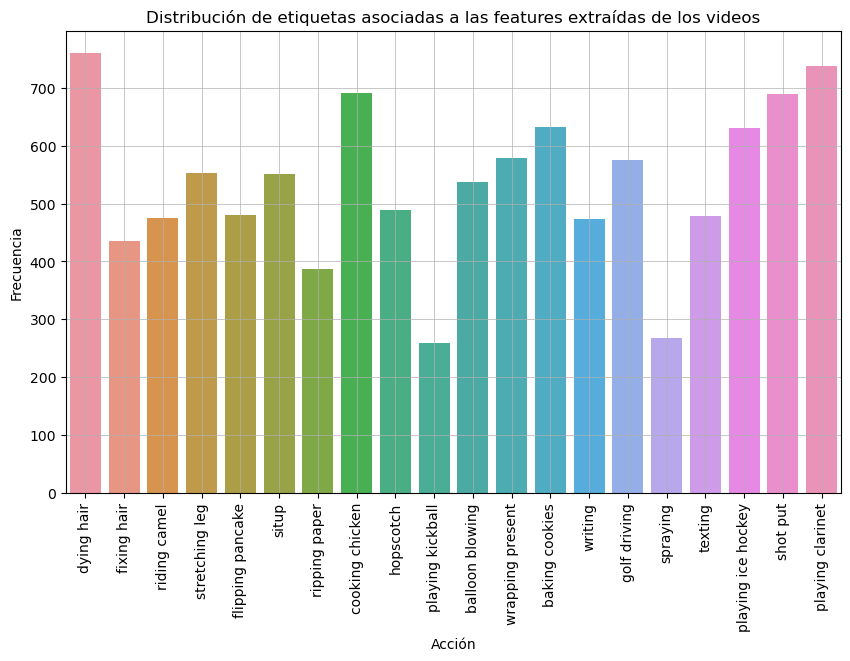

In [26]:
df_train = X_train.copy()
df_train['action'] = Y_train

sns.countplot(data = df_train, x = 'action')
plt.xlabel('Acción')
plt.ylabel('Frecuencia')
plt.title('Distribución de etiquetas asociadas a las features extraídas de los videos')
plt.xticks(rotation = 90)
plt.grid(True)
plt.show()

Se procede a realizar la normalización de datos, para ello utilizamos `PowerTransformer`, queremos que nuestra data tenga una forma gaussiana, pues los algoritmos de machine learning tienden a portarse mejor así, es decir, una distribución más cercana a la normal. El método 'Yeo-Johnson' permite el uso de información que contiene ceros ($0$) y valores negativos.

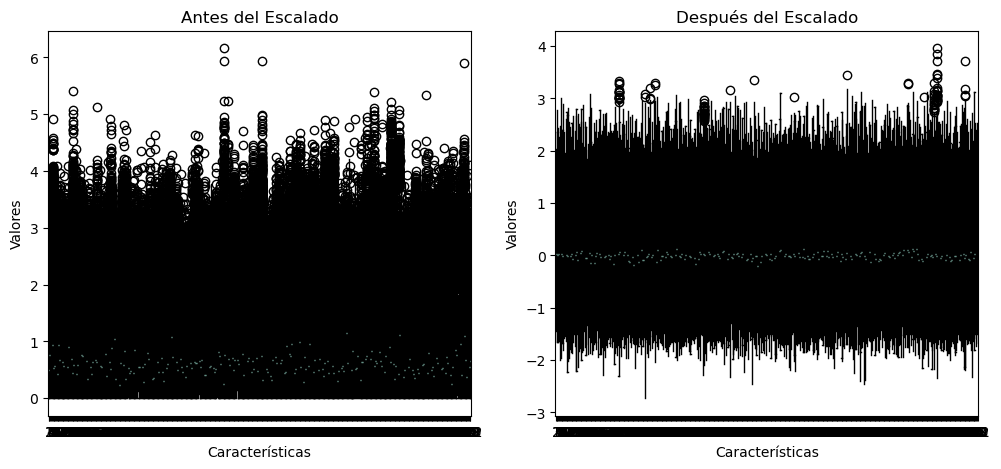

In [42]:
scaler = PowerTransformer()
X_train_norm = scaler.fit_transform(X_train)

_, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].boxplot(X_train)
ax[0].set_title('Antes del Escalado')
ax[0].set_xlabel('Características')
ax[0].set_ylabel('Valores')

ax[1].boxplot(X_train_norm)
ax[1].set_title('Después del Escalado')
ax[1].set_xlabel('Características')
ax[1].set_ylabel('Valores')

plt.grid(False)
plt.show()

Ahora, una vez hemos escalado nuestras características y notamos una mejora al buscar una distribución más cercana a la normal es momento de compararlo por medio de los histogramas. Es justamente por ello que notamos una gran mejora, ahora los puntos están más concentrados en escala, entre un rango de -2 a 2 aproximadamente, aún así contamos con datos outliers. A partir de esto ya tenemos un dataframe normalizado y estandarizado.

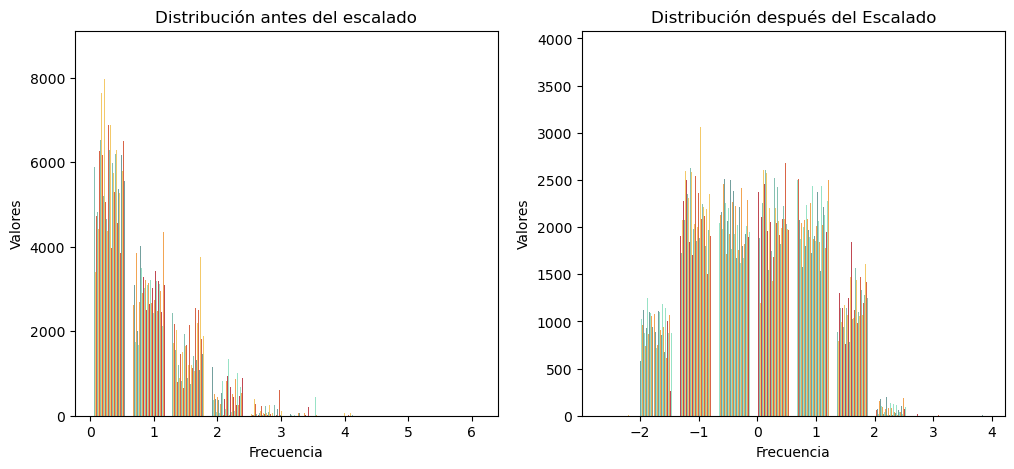

In [48]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(X_train)
ax[0].set_title('Distribución antes del escalado')
ax[0].set_xlabel('Frecuencia')
ax[0].set_ylabel('Valores')

ax[1].hist(X_train_norm)
ax[1].set_title('Distribución después del Escalado')
ax[1].set_xlabel('Frecuencia')
ax[1].set_ylabel('Valores')

plt.grid(False)
plt.show()

---
## 3. Dimensionality reduction

Usaremos **UMAP (Uniform Manifold Approximation and Projection)** que nos permitirá reducir la dimensionalidad preservando la estructura local de los datos mientras que a la vez conserva la estructura global. Estas bondados son sumamente importantes cuando se trabaja con conjuntos con gran volúmenes de datos como nuestro caso.

In [89]:
# Configurar UMAP
umap_scaler = umap.UMAP(n_components = 2)
umap_scaler_data = umap_scaler.fit_transform(X_train)
X_train_umap = pd.DataFrame(umap_scaler_data, columns=['UMAP1', 'UMAP2'])

print(f"Shape antes de aplicar UMAP: {X_train.shape}")
print(f"Shape después de aplicar UMAP: {X_train_umap.shape}")

Shape antes de aplicar UMAP: (10680, 512)
Shape después de aplicar UMAP: (10680, 2)


A continuación se va utilizar el método del codo, o más conocido como **Elbow Plot** que nos va permitir identificar el **número óptimo de clusters**, nos permite medir la inercia que indica qué tan bien fue clusterizada la información usando el algoritmo **K-Means** comparado con una cantidad $k$ de clusters. Se busca el punto de inflexión donde la inercia empieza a reducirse.

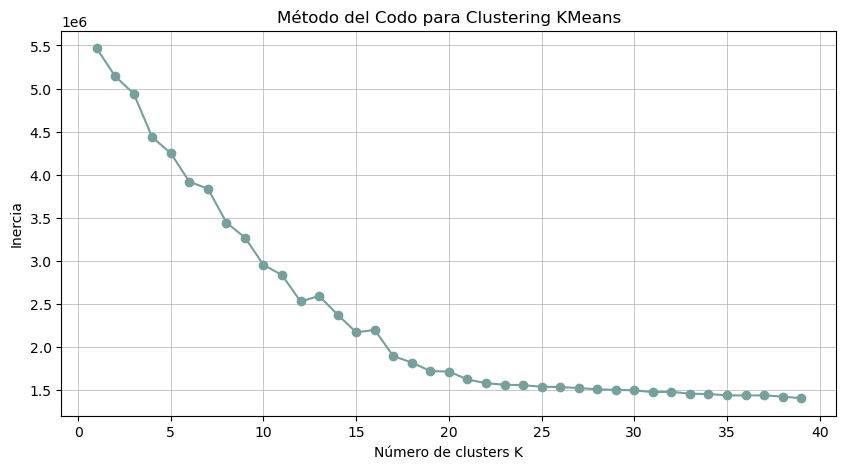

Número de clusters elegido por referencia de ElbowPlot: 20


In [99]:
max_range_k = 40
data = X_train_norm
fig = plt.subplots(figsize = (10, 5))

means_list = []
inertias_list = []

for current_k in range(1, max_range_k):
    kmeans = KMeans(n_clusters = current_k)
    kmeans.fit(data)

    means_list.append(current_k)
    inertias_list.append(kmeans.inertia_)

plt.plot(means_list, inertias_list, 'o-')
plt.title('Método del Codo para Clustering KMeans')
plt.xlabel('Número de clusters K')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

k_decision_clusters = 20
print(f'Número de clusters elegido por referencia de ElbowPlot: {k_decision_clusters}')    

En este punto hemos encontrado $k = 20$ clusters utilizando el método del codo. No obstante podemos probar para un $k$ en un rango de $\{18, 19, 20\}$ puesto que no se logra definir totalmente aquel punto de inflexión y queda a criterio del analista.

---
### 3. Clustering methods

TODO

#### 3.1 Density-based Method: KMeans
---

TODO JUSTIFICACION

In [170]:
import numpy as np

class Kmeans:
    def __init__(self, data, k, umbral):
        self.data = data
        self.k = k
        self.umbral = umbral
        self.centroides = self.init_centroides()
        self.inertia = 0  # Inicializar la inercia

    def init_centroides(self):
        num_points = self.data.shape[0]
        k_random_indices = np.random.choice(num_points, self.k, replace=False)
        return self.data[k_random_indices]

    def fit(self):
        movement = float('inf')
        while movement > self.umbral:
            clusters = self.get_clusters()
            new_centroides, new_inertia = self.update_centroides(clusters)
            movement = np.linalg.norm(self.centroides - new_centroides)
            self.centroides = new_centroides
            self.inertia = new_inertia  # Actualizar la inercia
        return self.centroides, clusters

    def get_clusters(self):
        distances = np.array([np.linalg.norm(self.data - centroide, axis=1) for centroide in self.centroides])
        return np.argmin(distances, axis=0)

    def update_centroides(self, clusters):
        new_centroides = []
        total_inertia = 0
        for idx in range(self.k):
            cluster_points = self.data[clusters == idx]
            if len(cluster_points) > 0:
                new_centroid = np.mean(cluster_points, axis=0)
                new_centroides.append(new_centroid)
                # Sumar la inercia de este cluster
                total_inertia += np.sum((cluster_points - new_centroid) ** 2)
            else:
                # Asignar un nuevo centroide aleatorio si no hay puntos en el cluster
                new_centroid = self.data[np.random.randint(0, len(self.data))]
                new_centroides.append(new_centroid)
        return np.array(new_centroides), total_inertia

#### 3.2 Density-based Method: DBSCAN
---
TODO

---
### 4. Classification metrics

Hay un criterio básico, los clusters serán buenos si existe cohesión inter-cluster ó intra-clusters, nosotros buscamos que los clusters estén lo más separado posibles entre sí, pero dentro de cada uno de estos ellos estén cohesivos, frente a esos datos tenemos una definición de buena clusterización.

In [171]:
class MetricsClustering:
    def __init__(self, X, model):
        self.X = X
        self.model = model
        self.labels = None
        self.silhouette = -1
        self.davies_bouldin = float('inf')
        
    def fit_predict(self):
        if hasattr(self.model, 'fit'):
            centroides, self.labels = self.model.fit()
        else:
            self.labels = self.model.fit_predict(self.X)
        self.calculate_silhouette()
        self.calculate_davies_bouldin()
        
    def calculate_silhouette(self):
        if np.unique(self.labels).size > 1:
            self.silhouette = silhouette_score(self.X, self.labels)
            
    def calculate_davies_bouldin(self):
        self.davies_bouldin = davies_bouldin_score(self.X, self.labels)

    def plot_clusters(self, title="Cluster Plot"):
        plt.figure(figsize=(10, 6))
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.labels, s=50, cmap='viridis', alpha=0.5)
        plt.title(title)
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.colorbar()
        plt.show()

El **coeficiente silueta** mide la cohesión de cada cluster independiente $i$ tal que calcula la distancia entre sus puntos y luego pasa a medir la distancia del punto $i$ con la de los puntos del clúster más cercano (el que podría afectar más a nuestro clúster por la cercanía). Esta métrica va desde $-1$ hacia $+1$. Mientras maś cercano a $1$, se indica que nuestros clusters están bien formados, la separación entre clusters $b > a$ es mayor a la distancia entre los puntos de un clúster $i$, es decir clases cohesivas y separadas, caso contrario tendríamos clusters superpuestos.

Por otro lado, el índice **Davies-Bouldin** es una métrica que nos sirve para identificar la separación entre diferentes clústers en un conjunto de datos, cuanto el valor sea menor, mejor será el clustering pues hay una correcta separación entre ellos y estarán bien definidos, es así entonces que en su forma más básica, en la división entre centroides se puede apreciar su importancia.

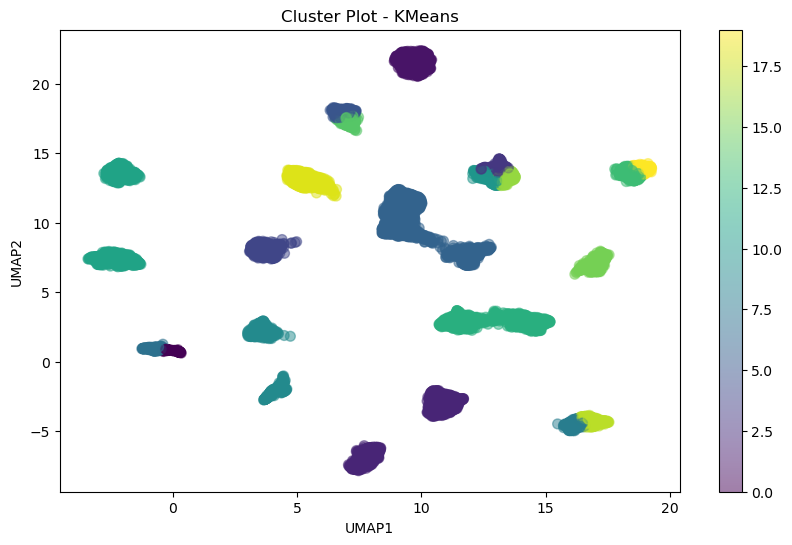

Silhouette Score: 0.5832915902137756
Davies Bouldin Score: 0.6647727853989274


In [189]:
data = X_train_umap.to_numpy()

k = 20  # después de determinar con el método del codo o silhouette
umbral = 0.5  # después de ajustar experimentalmente

kmeans = Kmeans(data, k, umbral)
centroides, clusters = kmeans.fit()

metrics_kmeans = MetricsClustering(data, kmeans)
metrics_kmeans.fit_predict()
metrics_kmeans.plot_clusters(title='Cluster Plot - KMeans')

print(f"Silhouette Score: {metrics_kmeans.silhouette}")
print(f"Davies Bouldin Score: {metrics_kmeans.davies_bouldin}")

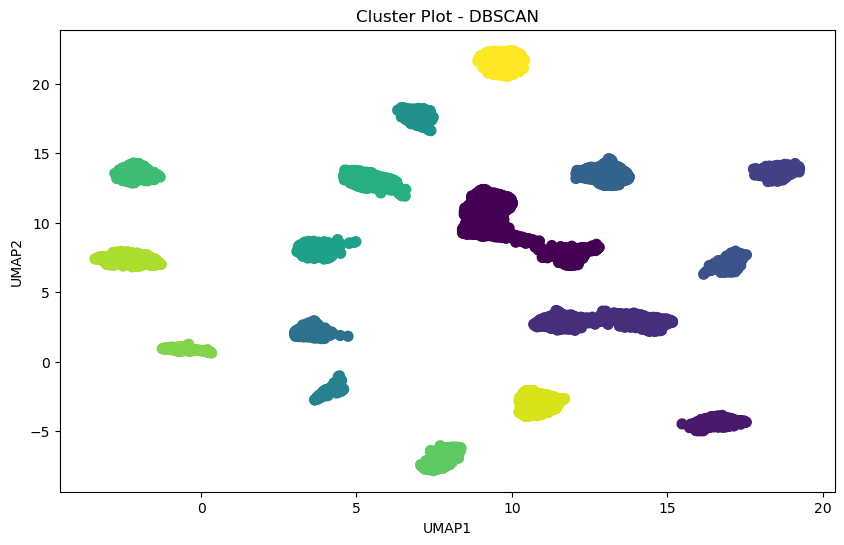

DBSCAN Silhouette Score: 0.7860255837440491
DBSCAN Davies Bouldin Score: 0.29531329129224976


In [133]:
dbscan_model = DBSCAN(eps=0.5, min_samples = 4)
metrics_dbscan = MetricsClustering(X_train_umap, dbscan_model)
metrics_dbscan.fit_predict()
metrics_dbscan.plot_clusters(title = 'Cluster Plot - DBSCAN')

print(f"DBSCAN Silhouette Score: {metrics_dbscan.silhouette}")
print(f"DBSCAN Davies Bouldin Score: {metrics_dbscan.davies_bouldin}")

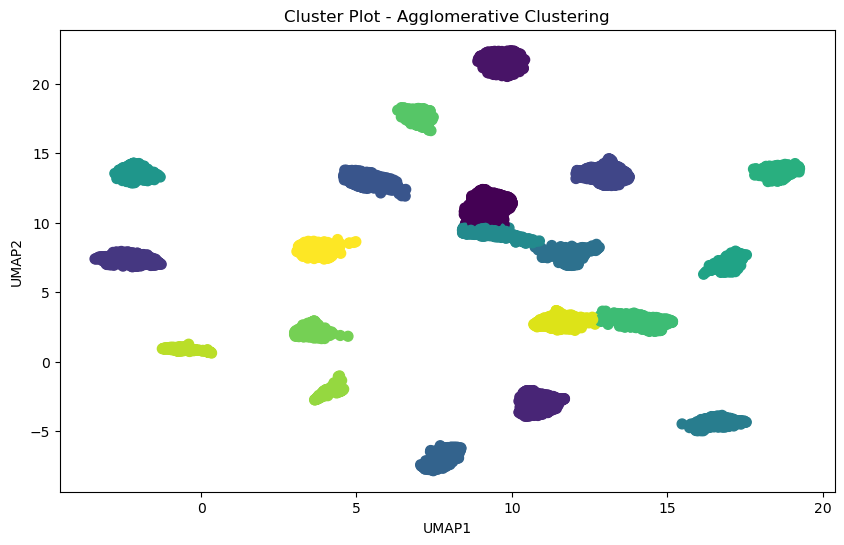

Agglomerative Silhouette Score: 0.8088157773017883
Agglomerative Davies Bouldin Score: 0.2659771632304729


In [118]:

# Usando la clase MetricsClustering para Agglomerative Clustering
agglo_model = AgglomerativeClustering(n_clusters=k_decision_clusters)
metrics_agglo = MetricsClustering(X_train_umap, agglo_model)
metrics_agglo.fit_predict()
metrics_agglo.plot_clusters(title = 'Cluster Plot - Agglomerative Clustering')

print(f"Agglomerative Silhouette Score: {metrics_agglo.silhouette}")
print(f"Agglomerative Davies Bouldin Score: {metrics_agglo.davies_bouldin}")